In [1]:
!pip install python-graphblas[default]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.9/350.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 11.9 MB/s eta 0:00:00


In [2]:
import graphblas as gb
gb.init("suitesparse", blocking=False)

from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder
from graphblas.io import mmread
import numpy as np

# **Наивный алгоритм**

Используя *python-graphblas* реализовать **наивный алгоритм**, для матрицы смежности вычисляющий и возвращающий количество треугольников неориентированного графа.

* Функция принимает представление неориентированного графа, удобное для неё
(загрузка, конвертация и проверка неориентированности реализованы отдельно).
* Функция возвращает число --- количество треугольников в графе.

In [3]:
def naiveA3(A):
  # шаг 1 - возведение матрицы смежности в квадрат и затем в куб
  A2 = A.mxm(A)
  A3 = A2.mxm(A)
  # шаг 2 - получение вектора из элементов по главной диагонали матрицы А3
  vector = A3.diag()
  # шаг 3 - подсчет суммы элементов по главной диагонали матрицы А3
  summa = vector.reduce(gb.agg.sum).value or 0
  # шаг 4 - деление на 6 полученной на предыдущем шаге суммы
  final = summa / 6
  return int(final)

# **Наивный алгоритм с маской**

Используя *python-graphblas* реализовать **наивный алгоритм с маской**, для матрицы смежности вычисляющий и возвращающий количество треугольников неориентированного графа.
* Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).
* Функция возвращает число --- количество треугольников в графе.

In [4]:
def naiveMaskA2(A):
  # шаг 1 - возводение матрицы смежности в квадрат
  A2 = A.mxm(A)
  # шаг 2 - применение маски к квадрату матрицы смежности
  masking = A2.dup(mask=A.dup(dtype=dtypes.BOOL))
  # шаг 3 - вычисление суммы построчных сумм элементов квадрата матрицы смежности с маской
  summa = masking.reduce_scalar(gb.monoid.plus).value or 0
  # шаг 4 - деление на 6 полученной на предыдущем шаге суммы
  final = summa / 6
  return int(final)

# **Сohen's algorithm**

Используя *python-graphblas* реализовать **Сohen's algorithm**, вычисляющий количество треугольников неориентированного графа.
* Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).
* Функция возвращает число --- количество треугольников в графе.

In [5]:
def cohen(A):
  # шаг 1 - разбиение матрицы смежности A на верхнетреугольную матрицу L и нижнетреугольную матрицу U
  L = gb.select.tril(A)
  U = gb.select.triu(A)
  # шаг 2 - подсчет матрицы B=LхU
  B = L.mxm(U)
  # шаг 3 - получение матрицы С путем поэлементного умножения матриц A на B с использованием маски
  C = B.dup(mask=A.dup(dtype=dtypes.BOOL))
  # шаг 4 - искомое число треугольников получаем как sum(C) деленное на 2
  final = int (C.reduce_scalar(gb.monoid.plus).value or 0) / 2
  return int(final)

# **Sandia algorithm**

Используя *python-graphblas* реализовать **Sandia algorithm**, вычисляющий количество треугольников неориентированного графа.
* Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).
* Функция возвращает число --- количество треугольников в графе.

In [6]:
def sandia(A):
  # шаг 1 - вычисление верхнетреугольной матрицы L из матрицы смежности А
  L = gb.select.tril(A)
  # шаг 2 - возведение в квадрат полученной матрицы L
  B = L.mxm(L)
  # шаг 3 - получение матрицы С путем поэлементного умножения матрицы L на B с использованием маски
  C = B.dup(mask=L.dup(dtype=dtypes.BOOL))
  # шаг 4 - получение итогового количества треугольников путем суммирования элементов матрицы C, полученной на предыдущем шаге
  final = int(C.reduce_scalar(gb.monoid.plus).value or 0)
  return int(final)

# **Дополнительно**
# **Подсчет количества треуголньков для вершин графа**

Используя *python-graphblas* реализовать **функцию, вычисляющую для каждой вершины неориентированного графа количество треугольников, в которых она участвует**.

* Функция принимает представление неориентированного графа, удобное для неё (загрузка, конвертация и проверка неориентированности реализованы отдельно).
* Функция возвращает массив, где для каждой вершины указано, в скольки треугольниках она участвует.

**Метод**: считать количество треугольников будем как диагональ куба матрицы смежности деленная пополам.

In [ ]:
def has_triangles(A):
  # получение куба матрицы смежности
  A2 = A.mxm(A)
  A3 = A2.mxm(A)
  # получение количества треугольников для вершин - взятие главной диагонали и деление на 2 каждого элемента
  # главная диагональ дает количество треуголников для каждой вершины х2, так как треугольники считаются по два раза
  n = A3.diag() / 2
  # получение количества строк графа
  rows = A.nrows
  # создание массива из количества треугольников для каждой вершины графа
  final = np.array([0] * rows)
  # заполнение массива количеством треугольников для каждой вершины графа
  idx, vals = n.to_coo()
  for i in range(len(idx)):
    final[idx[i]] = vals[i]
  return final

# **Тестирование**

Тесты для проверки корректности полученных реализаций.

**TEST 1**

Граф с 4 вершинами, где присутсвует **1 треуголник** с вершинами (0,1,2).

Вершины 0, 1 и 1 входят в **1 имеющийся треугольник** и вершина 3 не входит в этот треуго

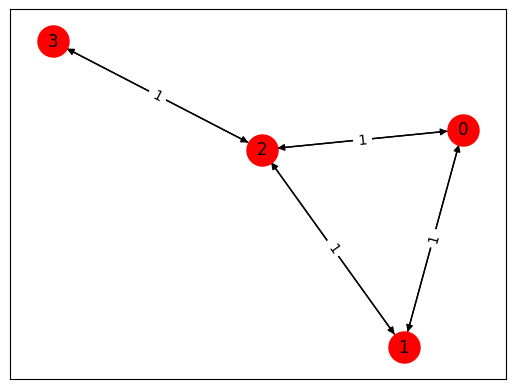

In [ ]:
M1 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 2, 0, 2, 3],
  [1, 0, 2, 1, 0, 2, 3, 2],
  [1, 1, 1, 1, 1, 1, 1, 1],
  nrows=4, ncols=4,)

gb.viz.draw(M1)

In [ ]:
print('Naive:', naiveA3(M1))
print('Naive_with_mask:', naiveMaskA2(M1))
print('Cohen:', cohen(M1))
print('Sandia:', sandia(M1))
print('Triangles amount:', has_triangles(M1))

Naive: 1
Naive_with_mask: 1
Cohen: 1
Sandia: 1
Triangles amount: [1 1 1 0]


**TEST 2**

Граф с 7 вершинами, где присутсвует **1 треуголник** с вершинами (1,4,5).

Вершины 1, 4 и 5 входят в **1 имеющийся треугольник** и все остальные вершины не входят ни в один треугольник.

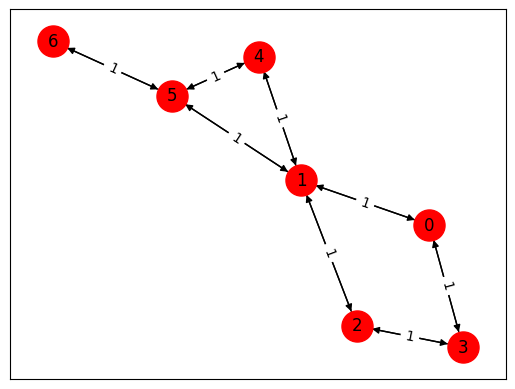

In [ ]:
M2 = gb.Matrix.from_coo(
  [1, 1, 2, 3, 1, 4, 5, 5, 5, 4, 1, 6, 0, 2, 3, 0],
  [0, 2, 3, 0, 4, 5, 1, 6, 4, 1, 5, 5, 1, 1, 2, 3],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  nrows=7, ncols=7,)

gb.viz.draw(M2)

In [ ]:
print('Naive:', naiveA3(M2))
print('Naive_with_mask:', naiveMaskA2(M2))
print('Cohen:', cohen(M2))
print('Sandia:', sandia(M2))
print('Triangles amount:', has_triangles(M2))

Naive: 1
Naive_with_mask: 1
Cohen: 1
Sandia: 1
Triangles amount: [0 1 0 0 1 1 0]


**TEST 3**

Граф с 7 вершинами, где присутсвует **3 треуголника** с вершинами (1,4,5), (1,2,3), (1,3,0).

Вершина 6 не входит ни в один треугольник, вершины 0, 2, 4 и 5 входят только в **1 треугольник**, вершина 3 входит в **2 треугольника** и вершина 1 входит во все **3 треугольника**.

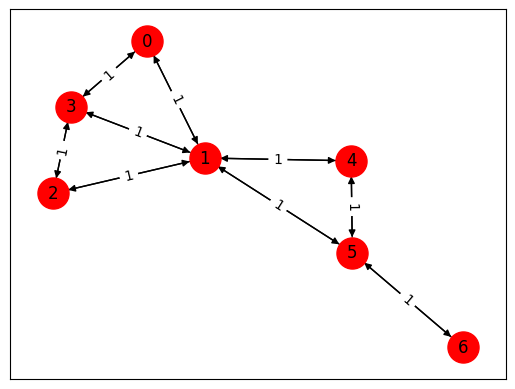

In [ ]:
M3 = gb.Matrix.from_coo(
  [1, 1, 2, 3, 1, 4, 5, 5, 5, 4, 1, 6, 0, 2, 3, 0, 1, 3],
  [0, 2, 3, 0, 4, 5, 1, 6, 4, 1, 5, 5, 1, 1, 2, 3, 3, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  nrows=7, ncols=7,)

gb.viz.draw(M3)

In [ ]:
print('Naive:', naiveA3(M3))
print('Naive_with_mask:', naiveMaskA2(M3))
print('Cohen:', cohen(M3))
print('Sandia:', sandia(M3))
print('Triangles amount:', has_triangles(M3))

Naive: 3
Naive_with_mask: 3
Cohen: 3
Sandia: 3
Triangles amount: [1 3 1 2 1 1 0]


**TEST 4**

Граф с 7 вершинами, где присутсвует **6 треуголников** с вершинами (1,4,5), (1,2,3), (1,3,0), (5,1,0), (1,4,2).

Вершина 6 входит только в **1 треуголник**, вершины 0, 2 и 3 входят в **2 треугольника**, вершины 4 и 5 входят в **3 треугольника** и вершина 1 входит в **5 треугольников**.

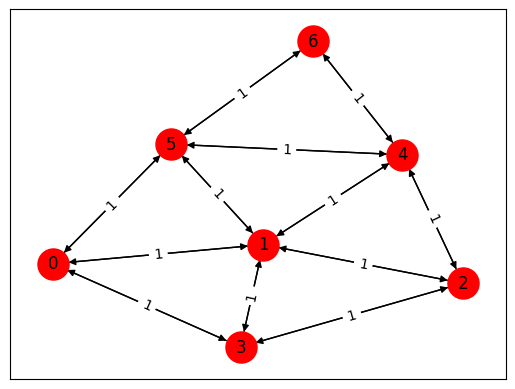

In [ ]:
M4 = gb.Matrix.from_coo(
  [1, 1, 2, 3, 1, 4, 5, 5, 5, 4, 1, 6, 0, 2, 3, 0, 1, 3, 5, 0, 4, 2, 6, 4],
  [0, 2, 3, 0, 4, 5, 1, 6, 4, 1, 5, 5, 1, 1, 2, 3, 3, 1, 0, 5, 2, 4, 4, 6],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  nrows=7, ncols=7,)

gb.viz.draw(M4)

In [ ]:
print('Naive:', naiveA3(M4))
print('Naive_with_mask:', naiveMaskA2(M4))
print('Cohen:', cohen(M4))
print('Sandia:', sandia(M4))
print('Triangles amount:', has_triangles(M4))

Naive: 6
Naive_with_mask: 6
Cohen: 6
Sandia: 6
Triangles amount: [2 5 2 2 3 3 1]


**TEST 5**

Граф с 7 вершинами, где присутсвует **0 треуголников**.

Соответсвенно, каждая вершина не входит ни в один треугольник.

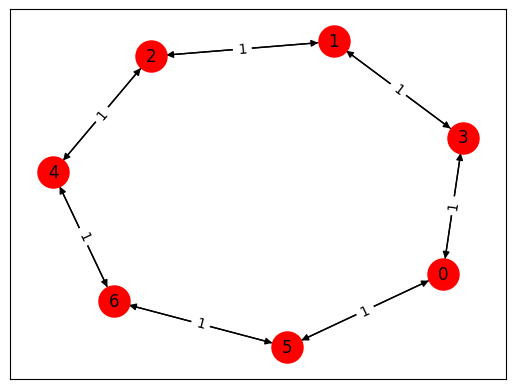

In [ ]:
M5 = gb.Matrix.from_coo(
  [0, 3, 1, 3, 1, 2, 4, 2, 4, 6, 6, 5, 5, 0],
  [3, 0, 3, 1, 2, 1, 2, 4, 6, 4, 5, 6, 0, 5],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  nrows=7, ncols=7,)

gb.viz.draw(M5)

In [ ]:
print('Naive:', naiveA3(M5))
print('Naive_with_mask:', naiveMaskA2(M5))
print('Cohen:', cohen(M5))
print('Sandia:', sandia(M5))
print('Triangles amount:', has_triangles(M5))

Naive: 0
Naive_with_mask: 0
Cohen: 0
Sandia: 0
Triangles amount: [0 0 0 0 0 0 0]


# **Дополнительно**

**Скачать 10 графов** в формате Matrix Market с сайта SuiteSparse Matrix Collection и **оценить время работы** всех полученных реализаций. Сделать выводы.
* В качестве фильтров для поиска графов на сайте использовать следующие значения: Rutherford-Boeing Type = Binary, Special Structure = Symmetric, Nonzeros.Min = 10000.

In [ ]:
# читаем 10 графов
graph1 = mmread('/content/EX5.mtx')
graph2 = mmread('/content/bcsstk32.mtx')
graph3 = mmread('/content/can_1054.mtx')
graph4 = mmread('/content/can_838.mtx')
graph5 = mmread('/content/delaunay_n11.mtx')
graph6 = mmread('/content/dwt_1242.mtx')
graph7 = mmread('/content/dwt_992.mtx')
graph8 = mmread('/content/email.mtx')
graph9 = mmread('/content/pkustk08.mtx')
graph10 = mmread('/content/power.mtx')

In [ ]:
# создаем массив графов
graphs = [graph1, graph2, graph3, graph4, graph5, graph6, graph7, graph8, graph9, graph10]

In [7]:
# создаем функцию реализации для алгоритмов с подсчетом времени выполнения
def alg_time(A):
  print('Naive:')
  %timeit naiveA3(A)
  print('Naive_with_mask:')
  %timeit naiveMaskA2(A)
  print('Cohen:')
  %timeit cohen(A)
  print('Sandia:')
  %timeit sandia(A)

In [ ]:
# Выводим нужные нам данные для сравнения результатов
for k in graphs:
  print('GRAPH with ', cohen(k), ' triangles')
  print('Количество вершин:', k.nrows, 'количество ребер:', {k.nvals})
  print(alg_time(k))

GRAPH with  295680  triangles
Количество вершин: 6545 количество ребер: {295680}
Naive:
2.86 s ± 565 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Naive_with_mask:
The slowest run took 4.04 times longer than the fastest. This could mean that an intermediate result is being cached.
182 ms ± 78.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Cohen:
31.7 ms ± 2.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Sandia:
22.3 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
GRAPH with  10381193  triangles
Количество вершин: 44609 количество ребер: {2014701}
Naive:
1.84 s ± 383 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Naive_with_mask:
464 ms ± 27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Cohen:
395 ms ± 72.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Sandia:
177 ms ± 48.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
GRAPH with  18842  triangles
Количество вершин: 1054 количество ребер: {12196}

In [ ]:
for k in graphs:
  print('GRAPH')
  print('Количество вершин:', k.nrows, 'количество ребер:', {k.nvals})
  print('Triangles amount max:', max(has_triangles(k)))
  %timeit has_triangles(k)

GRAPH
Количество вершин: 6545 количество ребер: {295680}
Triangles amount max: 144
2.9 s ± 408 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GRAPH
Количество вершин: 44609 количество ребер: {2014701}
Triangles amount max: 3964
The slowest run took 4.06 times longer than the fastest. This could mean that an intermediate result is being cached.
2.66 s ± 1.72 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
GRAPH
Количество вершин: 1054 количество ребер: {12196}
Triangles amount max: 158
13.7 ms ± 8.31 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
GRAPH
Количество вершин: 838 количество ребер: {10010}
Triangles amount max: 153
8.21 ms ± 404 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
GRAPH
Количество вершин: 2048 количество ребер: {12254}
Triangles amount max: 12
13.4 ms ± 7.41 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
GRAPH
Количество вершин: 1242 количество ребер: {10426}
Triangles amount max: 35
The slowest run took 4.11 times longer t

**Результаты тестирования реализованных алгоритмов**

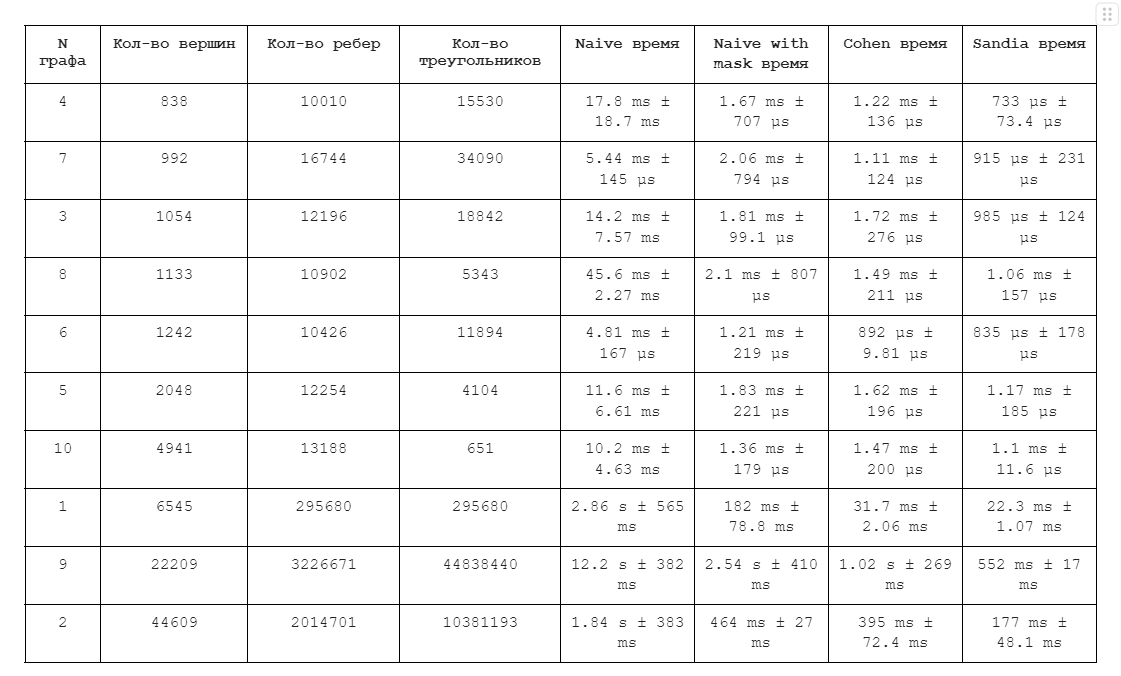

Результаты в таблице отсортированы по увеличению количества вершин в графе

**Выводы:**
1. Наивный алгоритм работает дольше всех на графах с любым количеством вершин и ребер, что обосновано сложностью внутренних вычислений. Причем, логично, что с уменьшенией разряжанности графа, увеличивается сложность вычислений.
2. Другие алгоритмы работают гораздо быстрее Наивного алгоритма, особенно разницу в скачке видно на графах с бОльшим количеством вершин и ребер. Меньшее время реализации достигается благодаря тому, что не берется куб матрицы смежности, как это делается в Наивном алгоритме.
3. Самым быстрым алгоритмом является алгоритм Сандиа, следующий по скорости идет алгоритм Кохена и дальше уже Наивный алгоритм с маской и просто Наивный алгоритм.

# **Дополнительно**

Реализовать **генератор случайных неориентированных графов**, в котором можно задавать количество вершин и степень разреженности графа. Путём генерации случайных графов различного размера и с разной степенью разреженности, **оценить время работы всех полученных реализаций и исследовать границы их применимости**. Сделать выводы.

In [8]:
import random

In [9]:
# n_rows - количество вершин графа, density - условно, насколько матрица смежности разряженная
def graph_generator(n_rows, density):
  # создание пустой матрицы размера n_rows на n_rows
  A = gb.Matrix(int, n_rows, n_rows)
  # ограничение на количество итераций
  while density > 0:
      # генерация рандомных чисел для матрицы смежности в интервале от 0 до количества ребер -1
      i = random.randint(0, n_rows - 1)
      j = random.randint(0, n_rows - 1)
      # проверка, что для данной ячеки еще не генерировались значения
      if A.get(i,j) is None and i != j:
          # заполнение матрицы смежности - записываем '1' в ячейку с только что сгенерированными числами и в смежную ей ячейку
          A[i,j] = 1
          A[j,i] = 1
          density = density - 1
  return A

Проверим на простом графе, что функция работает, сгенерировав матрицу смежности полностью заполненную размера 3 на 3 и построив граф по матрице смежности.

In [ ]:
a = graph_generator(3, 3)
print(a)

"M_1069131"  nvals  nrows  ncols  dtype         format
gb.Matrix        6      3      3  INT64  bitmapr (iso)
------------------------------------------------------
   0  1  2
0     1  1
1  1     1
2  1  1   


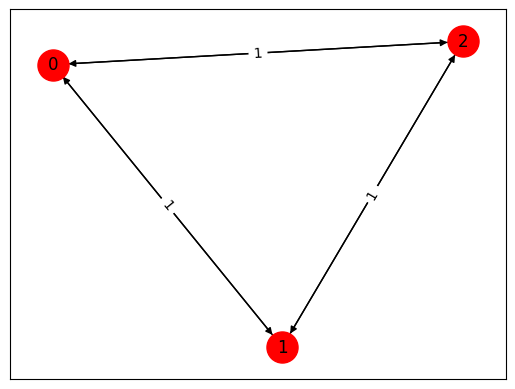

In [ ]:
gb.viz.draw(a)

Теперь посмотрим, как ведут себя реализованные алгоритмы на генерирующихся графах. Будем расматривать графы со следующим количеством вершин - [10, 25, 50, 75, 100, 250, 500, 750, 1000]

Разряженность графа будем брать следующим образом:

vals (максимальное количество непустых значений в строющейся матрицы указанного значения) = *n_rows * n_rows - n_rows* (т.е. количество вершин в квадрате минус количество вершин, чтобы убрать диагональ матрицы)

* *density = vals / 2* - максимально заполненная матрица смежности

* *density = vals / 2 * 0.75* - матрица смежности заполнена на 75%

* *density = vals / 2 * 0.5* - матрица смежности заполнена на 50%

* *density = vals / 2 * 0.25* - матрица смежности заполнена на 25%

Соответсвенно, чем меньше заполнена матрица смежности, тем более разряженный граф.






In [20]:
# считаем необходимые нам степени разряженности графа для дальнейшей генерации
vertex = [10, 25, 50, 75, 100, 250, 500, 750, 1000]
quantity = []
for v in vertex:
  density = int((v*v - v) / 2)
  quantity.append(density)
  quantity.append(int(density * 0.75))
  quantity.append(int(density * 0.5))
  quantity.append(int(density * 0.25))
  print('For', v, 'vetexes:', quantity)
  quantity = []

For 10 vetexes: [45, 33, 22, 11]
For 25 vetexes: [300, 225, 150, 75]
For 50 vetexes: [1225, 918, 612, 306]
For 75 vetexes: [2775, 2081, 1387, 693]
For 100 vetexes: [4950, 3712, 2475, 1237]
For 250 vetexes: [31125, 23343, 15562, 7781]
For 500 vetexes: [124750, 93562, 62375, 31187]
For 750 vetexes: [280875, 210656, 140437, 70218]
For 1000 vetexes: [499500, 374625, 249750, 124875]


Посмотрим время работы реализованных алгоритмов на графах с разными количествами вершин - от меньшего количества к большему, и с разной степенью разряженности.

In [ ]:
# 10 veryexes
rows = 10
density = [45, 33, 22, 11]
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', {k.nvals})
  print(alg_time(k))

Количество вершин: 10 количество ребер: {90}
Naive:
231 µs ± 50.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Naive_with_mask:
251 µs ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Cohen:
285 µs ± 7.25 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Sandia:
210 µs ± 32.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
None
Количество вершин: 10 количество ребер: {66}
Naive:
198 µs ± 8.05 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Naive_with_mask:
167 µs ± 34.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Cohen:
419 µs ± 72.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Sandia:
207 µs ± 46.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
Количество вершин: 10 количество ребер: {44}
Naive:
208 µs ± 10.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Naive_with_mask:
166 µs ± 28.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Cohen:
341 µs ± 129 µs per loo

In [21]:
# 25 veryexes
rows = 25
density = [300, 225, 150, 75]
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', {k.nvals})
  print(alg_time(k))

Количество вершин: 25 количество ребер: {600}
Naive:
The slowest run took 5.10 times longer than the fastest. This could mean that an intermediate result is being cached.
522 µs ± 408 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Naive_with_mask:
256 µs ± 86.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Cohen:
325 µs ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Sandia:
234 µs ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
Количество вершин: 25 количество ребер: {450}
Naive:
377 µs ± 9.28 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Naive_with_mask:
329 µs ± 55.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Cohen:
482 µs ± 180 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Sandia:
247 µs ± 5.02 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
Количество вершин: 25 количество ребер: {300}
Naive:
388 µs ± 7.77 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Na

In [17]:
# 50 veryexes
rows = 50
density = [1225, 918, 612, 306]
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', {k.nvals})
  print(alg_time(k))

Количество вершин: 50 количество ребер: {2450}
Naive:
763 µs ± 101 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Naive_with_mask:
542 µs ± 147 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Cohen:
749 µs ± 185 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Sandia:
558 µs ± 98.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
Количество вершин: 50 количество ребер: {1836}
Naive:
1.54 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Naive_with_mask:
1.14 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Cohen:
960 µs ± 162 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Sandia:
1.08 ms ± 300 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
Количество вершин: 50 количество ребер: {1224}
Naive:
1.64 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Naive_with_mask:
901 µs ± 55.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Cohen:
791 µs ± 135 µs per loop

In [22]:
# 75 veryexes
rows = 75
density = [2775, 2081, 1387, 693]
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', {k.nvals})
  print(alg_time(k))

Количество вершин: 75 количество ребер: {5550}
Naive:
2.03 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Naive_with_mask:
1.48 ms ± 508 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Cohen:
1.24 ms ± 471 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Sandia:
662 µs ± 13.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
Количество вершин: 75 количество ребер: {4162}
Naive:
5.9 ms ± 3.03 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Naive_with_mask:
2.37 ms ± 73.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Cohen:
1.64 ms ± 440 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Sandia:
1.81 ms ± 799 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
Количество вершин: 75 количество ребер: {2774}
Naive:
9.14 ms ± 3.8 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Naive_with_mask:
2.46 ms ± 653 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Cohen:
2 ms ± 971 µs per loop (

In [ ]:
# 100 veryexes
rows = 100
density = [4950, 3712, 2475, 1237]
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', {k.nvals})
  print(alg_time(k))

Количество вершин: 100 количество ребер: {9900}
Naive:
3.79 ms ± 189 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Naive_with_mask:
2.26 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Cohen:
2.2 ms ± 731 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Sandia:
1.89 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
Количество вершин: 100 количество ребер: {7424}
Naive:
15.4 ms ± 7.09 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Naive_with_mask:
4.73 ms ± 71.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Cohen:
2.42 ms ± 95.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Sandia:
2.16 ms ± 824 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
None
Количество вершин: 100 количество ребер: {4950}
Naive:
20.3 ms ± 9.96 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Naive_with_mask:
The slowest run took 4.40 times longer than the fastest. This could mean that an intermediate resul

In [18]:
# 250 veryexes
rows = 250
density = [31125, 23343, 15562, 7781]
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', {k.nvals})
  print(alg_time(k))

Количество вершин: 250 количество ребер: {62250}
Naive:
71.3 ms ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Naive_with_mask:
29.9 ms ± 718 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Cohen:
16.1 ms ± 4.12 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
Sandia:
8.37 ms ± 92.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество вершин: 250 количество ребер: {46686}
Naive:
92.7 ms ± 583 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Naive_with_mask:
81.8 ms ± 18.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Cohen:
26.1 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Sandia:
16.5 ms ± 3.91 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество вершин: 250 количество ребер: {31124}
Naive:
125 ms ± 26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Naive_with_mask:
55.6 ms ± 609 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Cohen:
24.9 ms ± 3.66 ms per loop 

In [ ]:
# 500 veryexes
rows = 500
density = [124750, 93562, 62375, 31187]
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', {k.nvals})
  print(alg_time(k))

Количество вершин: 500 количество ребер: {249500}
Naive:
681 ms ± 241 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Naive_with_mask:
364 ms ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Cohen:
157 ms ± 50.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Sandia:
76.8 ms ± 14.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество вершин: 500 количество ребер: {187124}
Naive:
1.26 s ± 525 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Naive_with_mask:
498 ms ± 4.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Cohen:
208 ms ± 38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Sandia:
141 ms ± 30.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество вершин: 500 количество ребер: {124750}
Naive:
1.22 s ± 220 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Naive_with_mask:
594 ms ± 166 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Cohen:
209 ms ± 39.7 ms per loop (mean ± std. dev. of 7 

In [19]:
# 750 veryexes
rows = 750
density = [280875, 210656, 140437, 70218]
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', {k.nvals})
  print(alg_time(k))

Количество вершин: 750 количество ребер: {561750}
Naive:
1.87 s ± 596 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Naive_with_mask:
962 ms ± 229 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Cohen:
296 ms ± 4.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Sandia:
185 ms ± 40.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество вершин: 750 количество ребер: {421312}
Naive:
2.88 s ± 365 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Naive_with_mask:
1.86 s ± 329 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Cohen:
603 ms ± 5.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Sandia:
357 ms ± 66.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 750 количество ребер: {280874}
Naive:
3.51 s ± 776 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Naive_with_mask:
1.55 s ± 120 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Cohen:
627 ms ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 

In [ ]:
# 1000 veryexes
rows = 1000
density = [499500, 374625, 249750, 124875]
for d in density:
  k = graph_generator(rows, d)
  print('Количество вершин:', k.nrows, 'количество ребер:', {k.nvals})
  print(alg_time(k))

Количество вершин: 1000 количество ребер: {999000}
Naive:
4.42 s ± 881 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Naive_with_mask:
2.02 s ± 315 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Cohen:
908 ms ± 224 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Sandia:
383 ms ± 9.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 1000 количество ребер: {749250}
Naive:
7.51 s ± 1.18 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Naive_with_mask:
5.75 s ± 1.01 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Cohen:
2.24 s ± 784 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Sandia:
745 ms ± 9.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 1000 количество ребер: {499500}
Naive:
7.81 s ± 629 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Naive_with_mask:
4.56 s ± 1.08 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Cohen:
1.25 s ± 7.13 ms per loop (mean ± std. dev. of 7 runs, 1

**Выводы:**


1.   Наивный алгоритм все также работает дольше всех. Если на графе с 10 вершинами Наивный алгоритм идет примерно на ровне со всеми другими, иногда даже выигрывая по времени у других алгоритмов, то уже на графе с 25 вершинами Наивный алгоритм выигрывает повремени лишь у алгоритма Кохена. А на графе с 50 вершинами Наивный алгоритм начинает работать уже дольше всех. Затем по времени выполнения идет Наивный алгоритм с маской, алгоритм Кохема и быстрее всех с задачей справляется алгоритм Сандиа.
2.   Если сравнивать алгоритмы Кохена и Сандиа, то с увеличением количества вершин все более показательно, что Сандиа все-таки быстрее. А также, скорее всего эффективнее в использование памяти, так как только этот алгоритм хранит только часть матрицы смежности.
3.   Также достаточно очевидно, что с уменьшением разряженности графа, увеличивается время работы алгоритма, что более показательно видно при увеличение количества вершин в графе. Тем не менее при полном заполнение матрицы смежности время работы алгоритмов опять уменьшается.
4. Наивный алгоритм и Наивный алгоритм с маской могут использовать в графах с небольшим количеством вершин, в то время как для больших неразряженных графов эффективнее использовать алгоритм Сандиа или Кохена.


